In [1]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib
import mne


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results, run_glm

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib as mpl
from mne.stats import fdr_correction, permutation_t_test


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations
import cross_conditional_comparison

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from 'c:\\Users\\annal\\fNIRs-data-pipeline\\python\\visualizations.py'>

In [2]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False

In [3]:
# FV Study Parameters
# ignore = [".DS_Store", ".git", "sub-14", "sub-18", ".gitignore"]
ignore = [".DS_Store", ".git", "sub-14", "sub-15", "sub-16", "sub-17", "sub-18", "sub-19", ".gitignore"]
columns_for_group_analysis = ['Neutral', 'Concern']
columns_for_glm_contrast = ['Neutral', 'Concern']
path = '../fNIRS_Data/'
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
columns_for_fdr = ['Neutral', 'Concern']
sc_present = False

In [4]:
# FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [5]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [6]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [7]:
# Live Drive
# ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../LiveDrive'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [8]:
# VR Driving
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Drive_VR/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [9]:
# Live Drive w/ Pause
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Driving_with_pause/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [10]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # print("Groups: ", groups)
    # print("DF: ", df)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        # print("Group: ", group)
        # print("df.eq(group): ", df.eq(group))
        paths = df[df.eq(group).any(axis=1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        print("sc_present group analysis", sc_present)
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, glm_results, contrasts = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_dict": contrasts, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results, glm_data

In [11]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, glm_results, contrasts = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_dict": contrasts, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results, glm_data

In [12]:
importlib.reload(analysis_tools)
importlib.reload(glm_analysis)
print(sc_present)
group_data, all_epochs, all_evokeds, glm_results, glm_data = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

# print(glm_results)


False
Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-01\nirs\2023-02-17_002.snirf


Reading 0 ... 8713  =      0.000 ...   856.488 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-02\nirs\2023-02-23_002.snirf
Reading 0 ... 8780  =      0.000 ...   863.074 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-03\nirs\2023-02-10_001.snirf
Reading 0 ... 9439  =      0.000 ...   927.854 secs...
Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-04\nirs\2023-02-10_002.snirf


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8961  =      0.000 ...   880.866 secs...
Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-05\nirs\2023-02-10_003.snirf


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9566  =      0.000 ...   940.338 secs...
Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-06\nirs\2023-02-10_004.snirf


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9282  =      0.000 ...   912.421 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-07\nirs\2023-02-17_001.snirf
Reading 0 ... 9460  =      0.000 ...   929.918 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-08\nirs\2023-02-17_002.snirf
Reading 0 ... 9088  =      0.000 ...   893.350 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-09\nirs\2023-03-01_004.snirf
Reading 0 ... 13102  =      0.000 ...  1287.927 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-10\nirs\2023-03-08_001.snirf
Reading 0 ... 11040  =      0.000 ...  1085.232 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-11\nirs\2023-02-10_001.snirf
Reading 0 ... 10100  =      0.000 ...   992.830 secs...
Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-12\nirs\2023-02-10_003.snirf


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 8750  =      0.000 ...   860.125 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Loading c:\Users\annal\fNIRs-data-pipeline\python\..\fNIRS_Data\group-test\sub-13\nirs\2023-03-09_001.snirf
Reading 0 ... 9146  =      0.000 ...   899.052 secs...


C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


sc_present group analysis False
SHORT CHANNEL PRESENT False
GLM Data Processed ---> Calcuating GLM Dataframe
{'epoch': <Epochs |  24 events (all good), -1.25 - 50 sec, baseline -1.25 – 0 sec, ~445 kB, data loaded,
 'Concern': 11
 'Neutral': 12
 'Start': 1>, 'condition': 'Concern', 'raw_haemo': <RawSNIRF | 2023-02-17_002.snirf, 36 x 685 (855.0 s), ~354 kB, data loaded>, 'raw_intensity': <RawSNIRF | 2023-02-17_002.snirf, 36 x 8714 (856.5 s), ~2.6 MB, data loaded>, 'f_path': '../fNIRS_Data//group-test/sub-01/nirs/2023-02-17_002.snirf', 'ID': 1, 'aux_df':         accelerometer_1_x  accelerometer_1_y  accelerometer_1_z  \
times                                                             
0.00                  NaN                NaN                NaN   
1.25                  inf               -inf               -inf   
2.50                  inf               -inf               -inf   
3.75                  inf               -inf               -inf   
5.00                  inf               

C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
# individual_data, all_epochs, all_evokeds, glm_data = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, trigger_id)
# individual_data

# Visualizations

C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\annal\fNIRs-data-pipeline\python\visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
c:\Users\annal\fNIRs-data-pipeline\python\visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

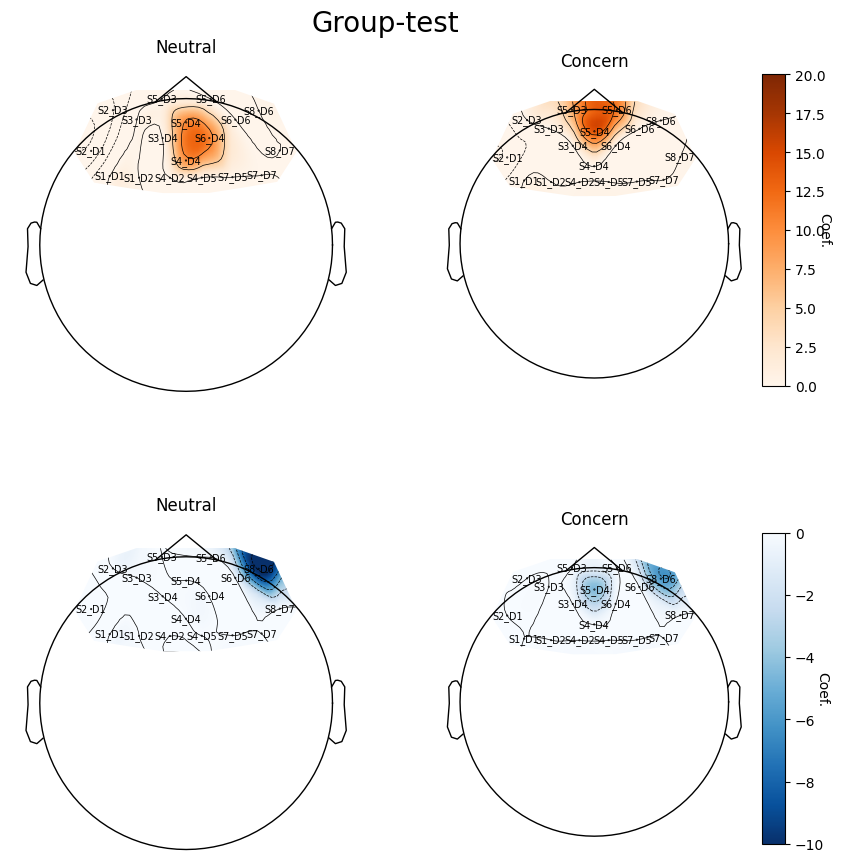

In [14]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_dict, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\annal\fNIRs-data-pipeline\python\cross_conditional_comparison.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contrast_df['fdr_status'] = reject_fdr
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, Conve

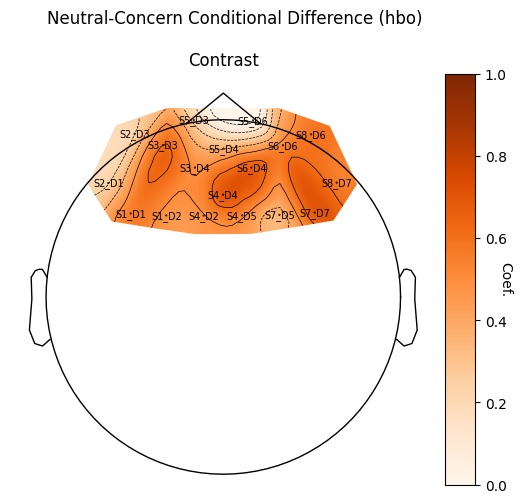

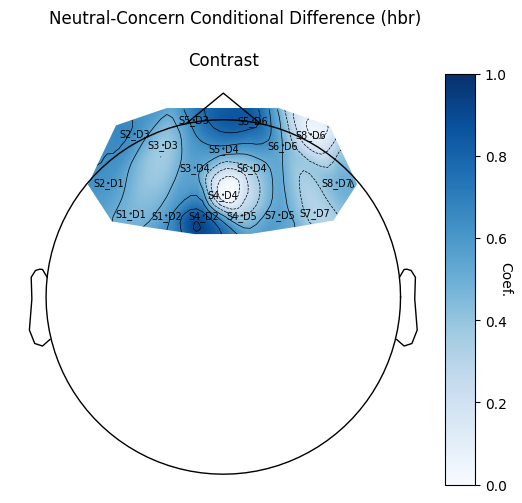

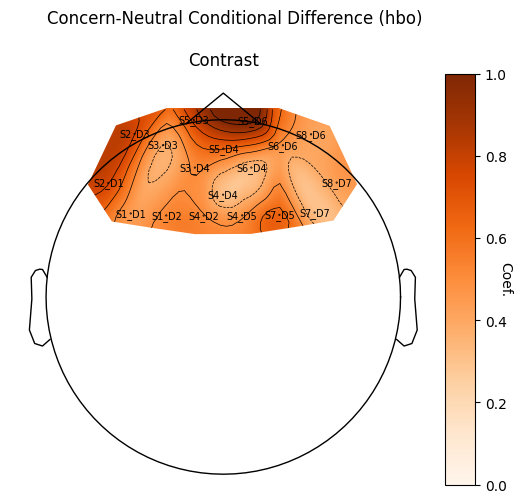

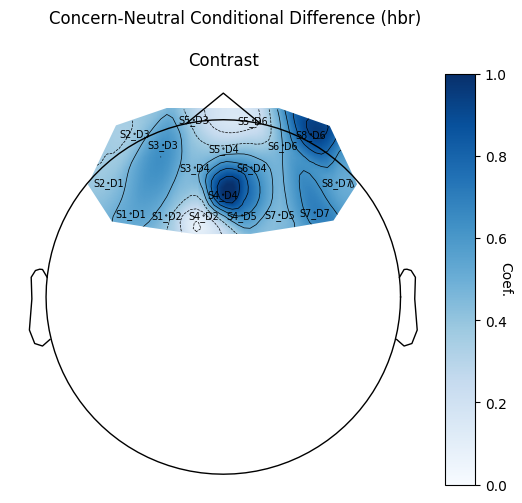

In [15]:
# Compare the results between two conditions
importlib.reload(visualizations)
importlib.reload(analysis_tools)
importlib.reload(cross_conditional_comparison)
epochs = []
raw_data = []

groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_dict, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']

cross_conditional_comparison.two_sample_permutation_test(group_data, raw_haemo, columns_for_glm_contrast, contrasts_dict)



In [16]:
# Generate FDR Corrected Results
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    
    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    
    # Find all the channels that survive FDR and are not drift values
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df_fdr)
    channels_df_fdr.to_csv('FV_results_FDR.csv')
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable Condition    df           mse   p_value            se         t  \
2478       Concern  21.0  2.888732e-12  0.000010  6.028842e-07  5.751643   
2856       Concern  21.0  3.850156e-13  0.000010  2.200997e-07 -5.751643   
27124      Neutral  21.0  3.949961e-12  0.000007  6.879842e-07  5.931251   
27502      Neutral  21.0  4.394964e-13  0.000007  2.294878e-07 -5.931251   

variable     theta Source Detector Chroma  Significant    ch_name  ID  \
2478      0.000003      5        4    hbo         True  S5_D4 hbo   2   
2856     -0.000001      5        4    hbr         True  S5_D4 hbr   2   
27124     0.000004      5        6    hbo         True  S5_D6 hbo  12   
27502    -0.000001      5        6    hbr         True  S5_D6 hbr  12   

variable  fdr_status  
2478            True  
2856            True  
27124           True  
27502           True  


In [17]:
# Permutation T-test

print(group_data)
for i in groups:
    all_data = group_data[i]['all_data']
    epochs = []
    for d in all_data:
        # epochs.append(data['epoch'])
        raw = d['raw_haemo']
        # picks = mne.pick_types(raw.info, fnirs=True, meg=False, eeg=False, stim=False, eog=True, exclude='bads')
        picks = mne.pick_types(raw.info, fnirs=True, meg=False, eeg=False, stim=False, eog=True, exclude=[])

        data = d['epoch'].get_data()
        times = d['epoch'].times

        temporal_mask = np.logical_and(0.04 <= times, times <= 0.06)
        data = np.mean(data[:, :, temporal_mask], axis=2)

        n_permutations = 50000
        T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=None)
        print(T0, H0)
        significant_sensors = picks[p_values <= 0.05]
        significant_sensors_names = [raw.ch_names[k] for k in significant_sensors]

        print(significant_sensors_names)


{'group-test': {'channels_df': variable Condition    df           mse   p_value            se         t  \
0          Concern  21.0  5.629719e-12  0.660527  7.783537e-07  0.445486   
1          Neutral  21.0  5.629719e-12  0.931628  7.626420e-07  0.086832   
2            Start  21.0  5.629719e-12  0.280215  2.298802e-06  1.108418   
3         constant  21.0  5.629719e-12  0.691688  9.105992e-07 -0.402080   
4          drift_1  21.0  5.629719e-12  0.767188  1.446280e-05 -0.299919   
...            ...   ...           ...       ...           ...       ...   
31423      drift_5  21.0  7.579167e-13  0.786960  7.779979e-06 -0.273739   
31424      drift_6  21.0  7.579167e-13  0.798028  7.472723e-06 -0.259170   
31425      drift_7  21.0  7.579167e-13  0.939593  7.570653e-06 -0.076694   
31426      drift_8  21.0  7.579167e-13  0.767242  7.339963e-06 -0.299847   
31427      drift_9  21.0  7.579167e-13  0.962662  7.645212e-06 -0.047375   

variable         theta Source Detector Chroma  Significa

C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\annal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


 [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


 [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


 [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


 [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


 [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


 [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']
Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 h

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [18]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


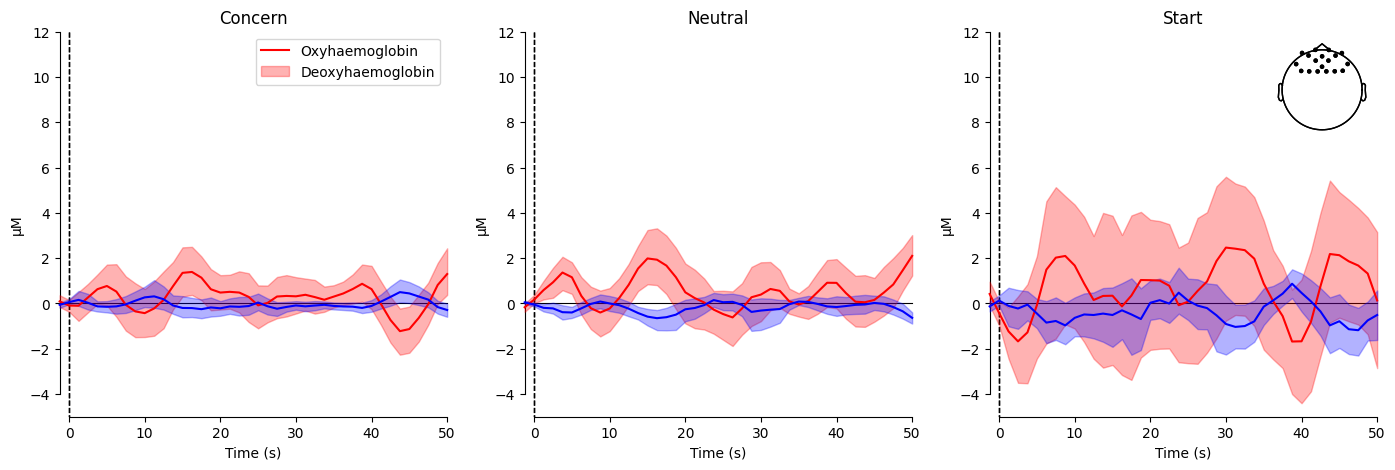

In [19]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [20]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [21]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e7
complete_results.to_csv('FV_results.csv')

           Coef. Std.Err.         z         P>|z|    [0.025    0.975] Chroma  \
0  -7.289050e-07      0.0 -2.045881  4.076804e-02 -0.000001      -0.0    hbo   
1  -1.344450e-06      0.0 -3.773585  1.609185e-04 -0.000002 -0.000001    hbo   
2  -1.045260e-06      0.0 -2.933822  3.348160e-03 -0.000002      -0.0    hbo   
3   9.068294e-07      0.0  2.545278  1.091909e-02       0.0  0.000002    hbo   
4   7.317545e-07      0.0  2.053880  3.998735e-02       0.0  0.000001    hbo   
5   1.372835e-06      0.0  3.853255  1.165577e-04  0.000001  0.000002    hbo   
6   1.056417e-06      0.0  2.965137  3.025478e-03       0.0  0.000002    hbo   
7   1.128150e-06      0.0  3.166477  1.542978e-03       0.0  0.000002    hbo   
8   1.107043e-06      0.0  3.107234  1.888466e-03       0.0  0.000002    hbo   
9   4.302680e-07      0.0  2.352644  1.864045e-02       0.0  0.000001    hbr   
10 -4.447087e-07      0.0 -2.431604  1.503212e-02 -0.000001      -0.0    hbr   
11 -5.789850e-07      0.0 -3.165808  1.5